# Implications Between Binary Word Embedding Features
We'd like to know the likelihood of implications between Word2Bits features. Before we estimate it, we need to grapple with the fact that in Word2Bits features, both `True` and `False` can signify the presence of a feature.

## Negated Features
First, we will negate those features $x$ that satisfy $P(\neg x\rightarrow y\mid\neg x) > P(x\rightarrow y\mid x)$ for all $y\neq x$. *Note that word embedding negations have no bearing on the Euclidean and cosine distances between word vectors.*

In [1]:
%%time
from gensim.models import KeyedVectors

embeddings = KeyedVectors.load_word2vec_format('1b_1000d_vectors_e10', binary=True).vectors.T > 0

CPU times: user 4.12 s, sys: 2.27 s, total: 6.4 s
Wall time: 3.79 s


In [2]:
import numpy as np

def pointwise_p(args):
    """Returns a sample estimate of P(x -> y | x).
    
    Parameters
    ----------
    negate_x : bool
        Whether the sample of x should be negated.
    negate_y : bool
        Whether the sample of y should be negated.
    index_x : int
        An index such that embeddings[index_x] is a sample of x.
    index_y : int
        An index such that embeddings[index_y] is a sample of y.
    
    Returns
    -------
    float
        A sample estimate of P(x -> y | x)
    """
    global embeddings
    negate_x, negate_y, index_x, index_y = args
    x = embeddings[index_x]
    y = embeddings[index_y]
    if negate_x:
        x = ~x
    if negate_y:
        y = ~y

    sum_x = np.sum(x)
    if sum_x > 0.0:
        return float(np.sum(x & y)) / sum_x
    return 0.0

In [3]:
%%time
from itertools import product
from multiprocessing import Pool
from operator import mul

with Pool(None) as pool:
    negate_x = (False, True)
    negate_y = (False, True)
    index_x = range(embeddings.shape[0])
    index_y = range(embeddings.shape[0])
    args = (negate_x, negate_y, index_x, index_y)
    p = pool.map(pointwise_p, product(*args))
p = np.reshape(p, (len(negate_x) + len(negate_y), len(index_x), len(index_y)))

CPU times: user 8.72 s, sys: 1.67 s, total: 10.4 s
Wall time: 10min 46s


In [4]:
argmax = p.argmax(axis=0)
negate_x = (argmax & 2**1 > 0)
np.fill_diagonal(negate_x, False)
p_negate_x = negate_x.sum(axis=0) / (embeddings.shape[0] - 1)

The following are the values of $P(P(\neg x\rightarrow y\mid\neg x) > P(x\rightarrow y\mid x))$ for all $x$:

In [5]:
import pandas as pd

with pd.option_context('display.max_columns', 10):
    display(pd.DataFrame(p_negate_x).T)

,0,1,2,3,4,...,995,996,997,998,999
0,0.531532,0.513514,0.48048,0.497497,0.511512,...,0.495495,0.513514,0.481481,0.510511,0.514515


There is almost zero correlation ($r\approx0.06$) between $P(P(\neg x\rightarrow y\mid\neg x) > P(x\rightarrow y\mid x))$ and $P(x\neq 0)$:

In [6]:
p_nonzero_x = embeddings.sum(axis=1) / embeddings.shape[1]
np.corrcoef(p_negate_x, p_nonzero_x)

array([[1.        , 0.06361295],
       [0.06361295, 1.        ]])

In [7]:
import numpy as np

def pointwise_p(args):
    """Returns a sample estimate of P(x -> y | x).
    
    Parameters
    ----------
    index_x : int
        An index such that embeddings[index_x] is a sample of x.
    index_y : int
        An index such that embeddings[index_y] is a sample of y.
    
    Returns
    -------
    float
        A sample estimate of P(x -> y | x)
    """
    global embeddings
    index_x, index_y = args
    x = embeddings[index_x]
    y = embeddings[index_y]

    sum_x = np.sum(x)
    if sum_x > 0.0:
        return float(np.sum(x & y)) / sum_x
    return 0.0

## Implication Graph
Second, we will construct a weighted digraph $G=(V,E,w)$ of features $V$, where $w(xy) = P(x\rightarrow y\mid x)$ and $xy\in E$ iff $w(xy)> w_{0.995}$. *We restrict ourselves to $w_{0.995}$ (the 99.5% quantile), so that the graph can be more easily drawn. Alternatively, we could construct a directed maximum spanning tree.*

In [8]:
import numpy as np

embeddings = np.load('1b_1000d_vectors_e10_negated.npy').T > 0

In [9]:
def pointwise_p(args):
    """Returns P(x -> y).
    
    Parameters
    ----------
    index_x : int
        An index such that embeddings[index_x] is x.
    index_y : int
        An index such that embeddings[index_y] is y.
    
    Returns
    -------
    float
        The value of P(x -> y).
    """
    global embeddings
    index_x, index_y = args
    x = embeddings[index_x]
    y = embeddings[index_y]
    
    return float(np.sum((x & y) | ~x)) / x.size

In [10]:
%%time
from itertools import product
from multiprocessing import Pool
from operator import mul

with Pool(None) as pool:
    index_x = range(embeddings.shape[0])
    index_y = range(embeddings.shape[0])
    args = (index_x, index_y)
    p = pool.map(pointwise_p, product(*args))
p = np.reshape(p, tuple(map(len, args)))

CPU times: user 485 ms, sys: 204 ms, total: 689 ms
Wall time: 6.88 s


The following are the values of $P(x\rightarrow y)$:

In [11]:
import pandas as pd

with pd.option_context('display.max_rows', 10, 'display.max_columns', 10):
    display(pd.DataFrame(p))

,0,1,2,3,4,...,995,996,997,998,999
0,1.000000,0.761344,0.796356,0.657334,0.747359,...,0.743039,0.749043,0.756772,0.724411,0.750810
1,0.739154,1.000000,0.786649,0.652803,0.740711,...,0.730050,0.738396,0.744554,0.713470,0.740136
2,0.701084,0.713568,1.000000,0.591926,0.696091,...,0.690017,0.693033,0.703315,0.667560,0.702641
3,0.843010,0.860670,0.872873,1.000000,0.848536,...,0.840373,0.842266,0.852113,0.828898,0.845030
4,0.747822,0.763364,0.791825,0.663324,1.000000,...,0.742394,0.747794,0.763252,0.727161,0.753868
...,...,...,...,...,...,...,...,...,...,...,...
995,0.756659,0.765861,0.798909,0.668317,0.755551,...,1.000000,0.760517,0.755888,0.735156,0.761429
996,0.757824,0.769368,0.797085,0.665372,0.756112,...,0.755677,1.000000,0.754696,0.731439,0.753349
997,0.746854,0.756828,0.788669,0.656520,0.752872,...,0.732351,0.735998,1.000000,0.717370,0.741384
998,0.779243,0.790492,0.817663,0.698054,0.781529,...,0.776367,0.777489,0.782118,1.000000,0.780421


In [12]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

threshold = np.quantile(p, 0.995)
print('We threshold P(x → y) at {}.'.format(threshold))
g = np.copy(p)
g[g < threshold] = 0.0
np.fill_diagonal(g, 0.0)
g[p <= p.T] = 0.0

We threshold P(x → y) at 0.9653533405338682.


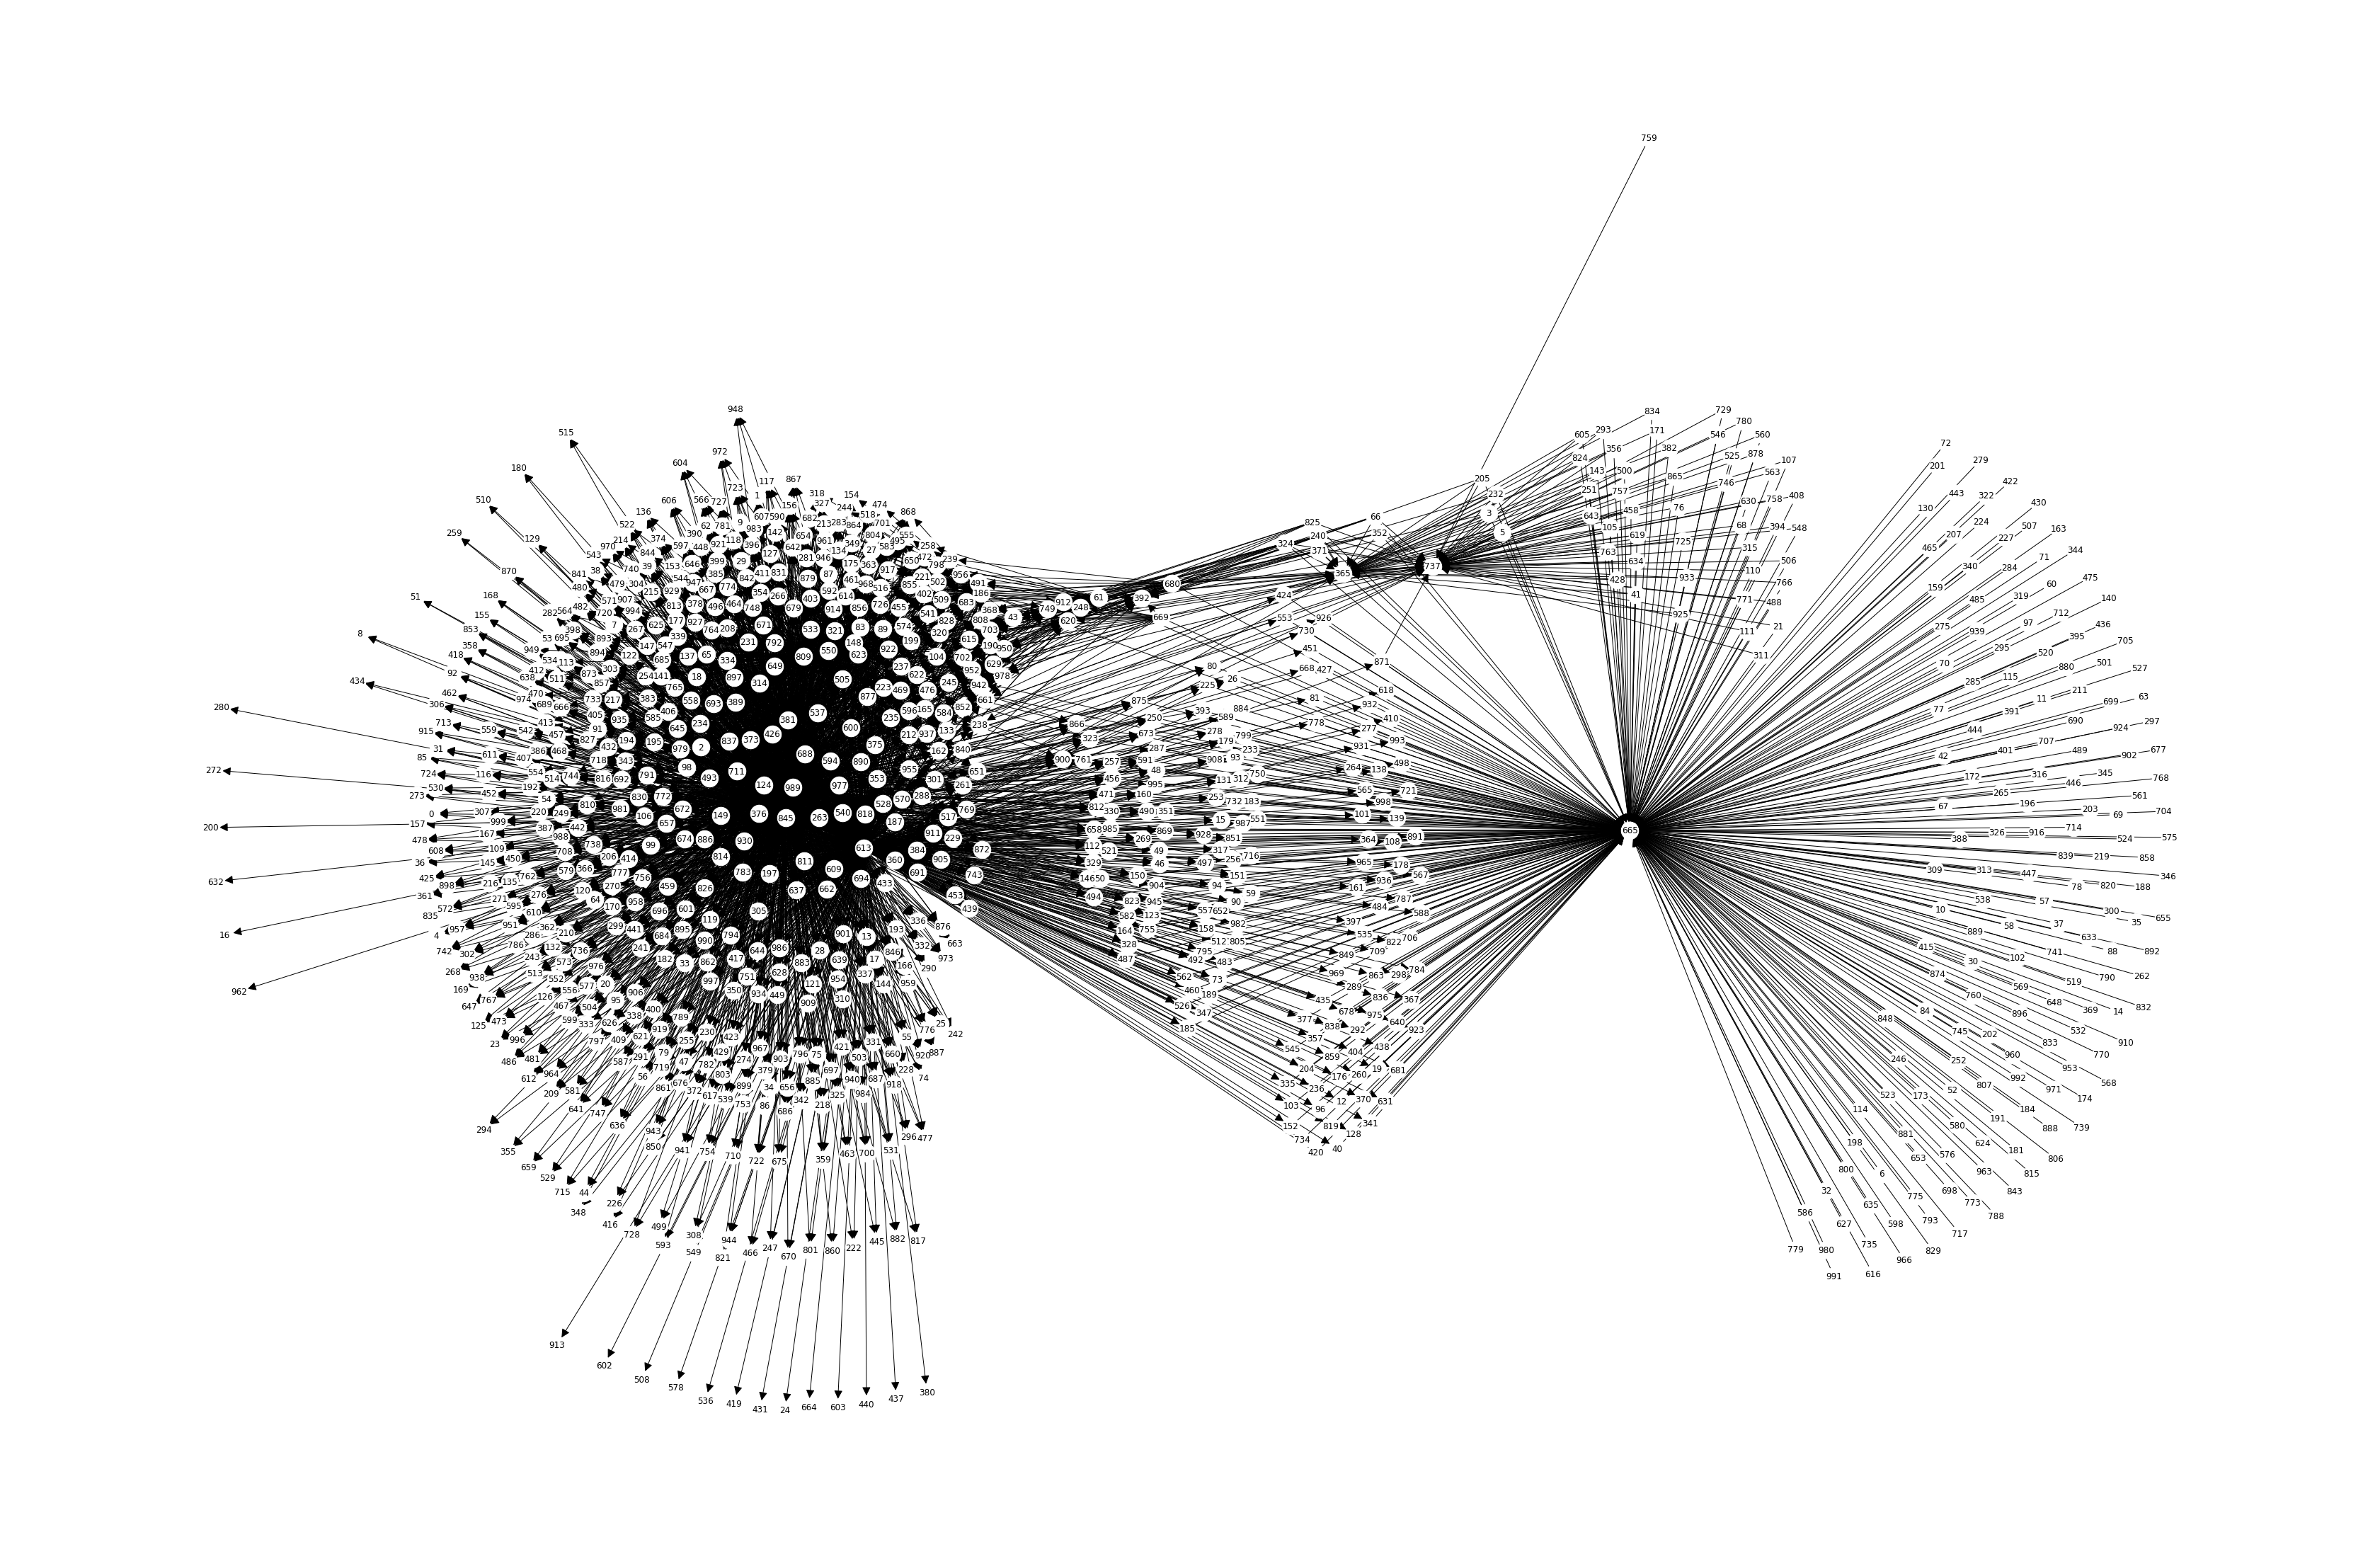

CPU times: user 45 s, sys: 2.98 s, total: 48 s
Wall time: 44.9 s


In [13]:
%%time
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for indices in np.argwhere(g > 0):
    weight = g[tuple(indices)]
    G.add_edge(*indices, weight=weight)

fig, ax = plt.subplots()
fig.set_figheight(40)
fig.set_figwidth(60)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='sfdp')
config = {
    'edgelist': edges,
    'edge_vmin': 0.0, 
    'edge_vmax': 1.0,
    'with_labels': True,
    'node_color': 'w',
    'node_size': 600,
    'arrowsize': 25,
}
nx.draw(G, pos, **config)
plt.savefig("embedding-implications.pdf")
plt.show()